In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import mplhep as hep
import pickle
from coffea.util import load
from coffea.hist import plot
import re

In [2]:
lumi_weights = None
with open("filefetcher/aram_samples.scales.pkl", "rb") as fin:
    lumi_weights = pickle.load(fin)
    lumi_weights["data_mu"] = 1.0
    lumi_weights["data_el"] = 1.0
output = load("hists_wpt_filefetcher_aram_sample.coffea")

In [3]:
from hist import Hist, Stack
data_mu = {name: h * lumi_weights[name] for name, h in output.items() if name.find("data") > -1 and name[-2:] == "mu"}
mc_mu = {name: h * lumi_weights[name] for name, h in output.items() if name.find("data") == -1 and name[-2:] == "mu"}
data_el = {name: h * lumi_weights[name] for name, h in output.items() if name.find("data") > -1 and name[-2:] == "el"}
mc_el = {name: h * lumi_weights[name] for name, h in output.items() if name.find("data") == -1 and name[-2:] == "el"}


In [4]:
mts_mu = [h["cent", ...].project("charge", "mt") for _, h in mc_mu.items()]
mts_mu_data = sum(h["cent", :, :1, ...] for h in data_mu.values()).project("charge","mt")
mts_mu_scaled = Stack(*mts_mu)

mts_el = [h["cent", ...].project("mt") for _, h in mc_el.items()]
mts_el_scaled = Stack(*mts_el)

In [5]:
print(data_mu["data_mu"]["cent", : , :, ...])

Hist(
  IntCategory([-1, 1], name='charge', label='q'),
  Variable([0, 1.4442, 2.4], name='abseta', label='|\\eta|'),
  Regular(12, 0, 120, name='mt', label='M_{T}^{W} (GeV)'),
  Variable([0, 8, 16, 24, 32, 40, 50, 70, 100], name='ptW', label='p_{T}^{W} (GeV)'),
  Variable([0, 8, 16, 24, 32, 40, 50, 70, 100], name='ptW_true', label='True p_{T}^{W} (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=2.22844e+06, variance=2.22844e+06) (WeightedSum(value=2.27403e+06, variance=2.27403e+06) with flow)


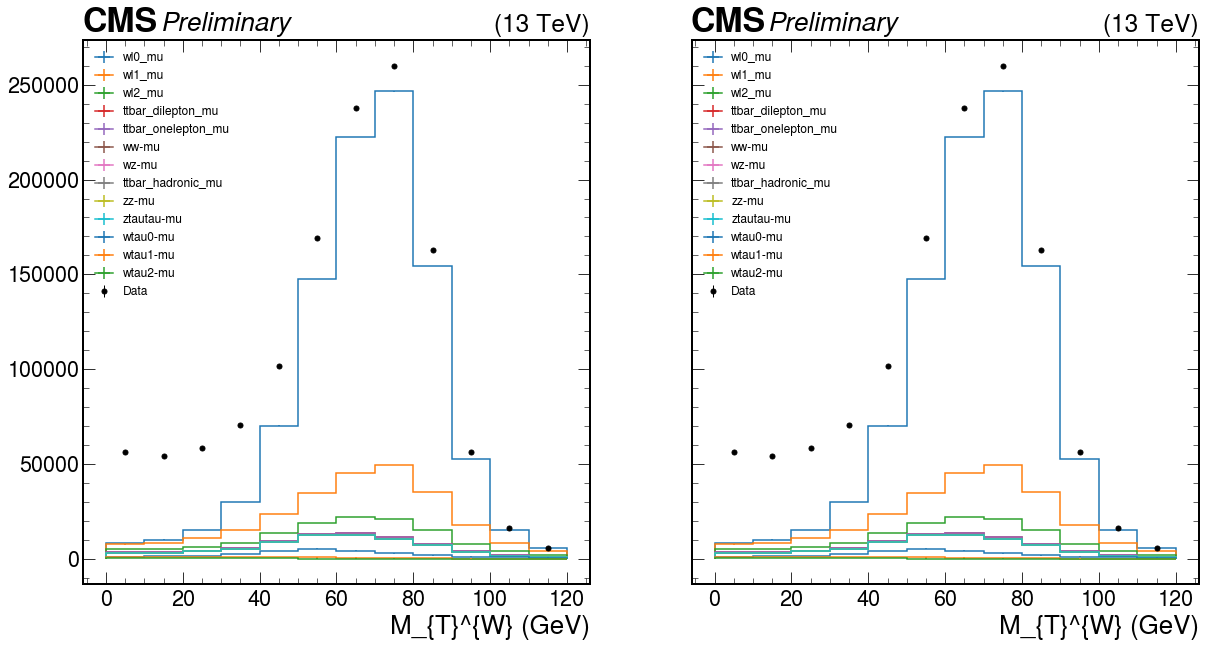

In [6]:
plt.style.use([hep.style.ROOT, hep.style.firamath])

f, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,10))

for i, q in enumerate([-1, 1]):
    hep.histplot([x[q, ...] for x in mts_mu_scaled], stack=True, label=[name for name, _ in mc_mu.items()], ax=axs[i])
    hep.histplot(mts_mu_data[q, ...], None, yerr=True, histtype="errorbar", label="Data", color="black", ax=axs[i])

    axs[i].legend(fontsize=12)
    hep.cms.label(loc=0, data=True, llabel="Preliminary", ax=axs[i])

plt.show()

In [ ]:
analysis["wl0_mu", "cent", ...].project("mt") * lumi_weights["wl0_mu"]

In [ ]:
plt.style.use([hep.style.ROOT, {'font.size': 16}])

# plot options for data
data_err_opts = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,
}

for i in range(0, int(round(len(output.keys())))-1, 2)[2:]:
    fig, ((ax1, ax2),(rax1, rax2)) = plt.subplots(2, 2, figsize=(16, 7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    fig.subplots_adjust(hspace=.07)
    h1name = list(output.keys())[i]
    h2name = list(output.keys())[i+1]
    if any([h1name.startswith('cutflow'), h2name.startswith('cutflow')]): break
    print(h1name, h2name)
    h1 = output[h1name]
    h2 = output[h2name]
    # if True: normalize histo to 1
    dense = False

    for ax, rax, h in zip([ax1, ax2], [rax1, rax2], [h1, h2]):
        # scale MC samples according to lumi (for now, dummy scale)
        scales = {
            'ttbar': 1.0,
            'ttbarprime':1.0
        }
        h.scale(scales,axis='dataset')   
        notdata = re.compile('(?!Data)')
        if hasattr(h, 'dim'):
            plot.plot1d(h[notdata], ax=ax, legend_opts={'loc':1}, density=dense, stack=True, clear=False);
            plot.plot1d(h["Data"], ax=ax, legend_opts={'loc':1}, density=dense, error_opts=data_err_opts, clear=False);
            # now we build the ratio plot
            plot.plotratio(
                   num=h["Data"].sum("dataset"),
                    denom=h[notdata].sum("dataset"),
                    ax=rax,
                    error_opts=data_err_opts,
                    denom_fill_opts={},
                    guide_opts={},
                    unc='num'
                )
        else:
            continue    
        #break
    for ax, rax, hname in zip([ax1, ax2], [rax1, rax2], [h1name, h2name]):
        at = AnchoredText(r"$1\mu, 1e$"+"\n"+
                           "2+ jets"+"\n"+
                          r"$|\eta| < 2.5$",
                           loc=2, frameon=False)
        ax.add_artist(at)
        ax.set_ylim(0.001, None)
        if hname.startswith("btag") or hname.startswith("DeepCSV_trackDecayLenVal"):
            ax.semilogy()
        rax.set_ylabel('Data/Pred.')
        rax.set_ylim(0,2)
        ax.set_xlabel(None)
        
    hep.mpl_magic(ax1)
    hep.mpl_magic(ax2)